In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
df = pd.read_csv("/content/telco_customer_churn.csv")

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

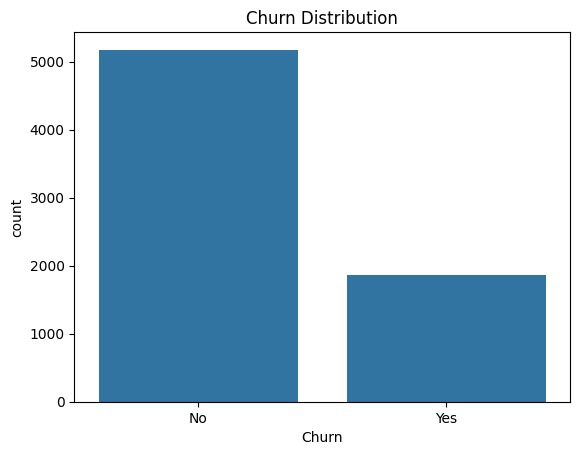

Churn Rate:
 Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64
************************************************** Check Data Types and Convert
************************************************** Missing Value Heatmap


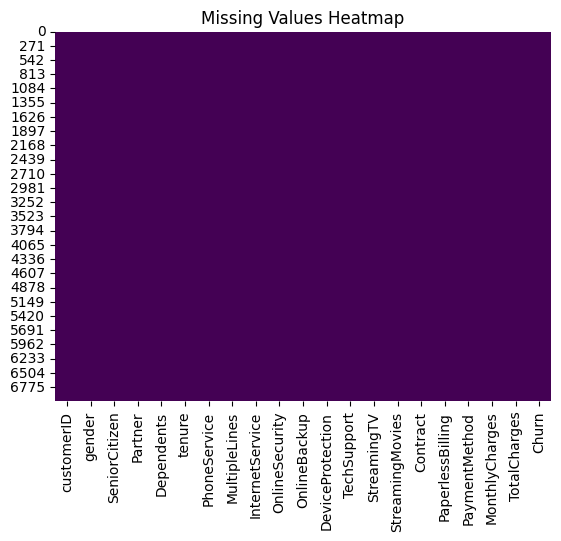

************************************************** Numerical Variable Histograms


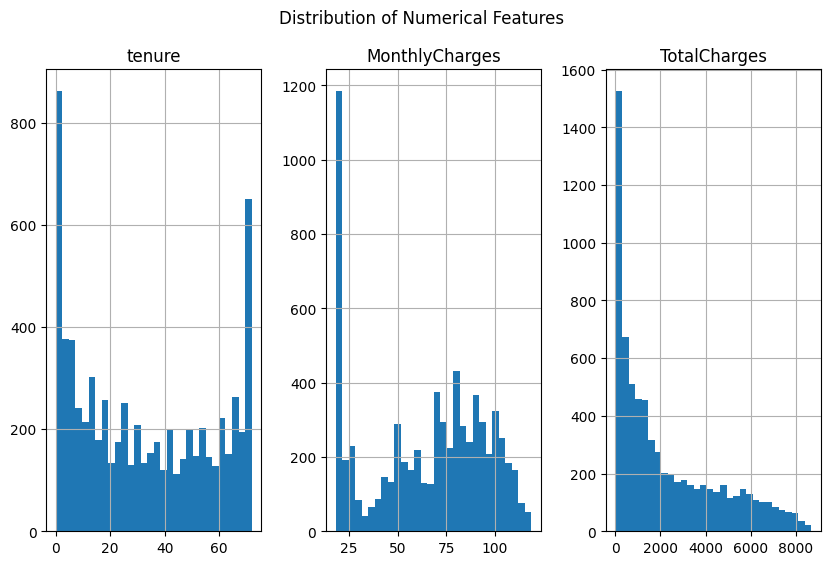

************************************************** Correlation Matrix (Numerical Only)


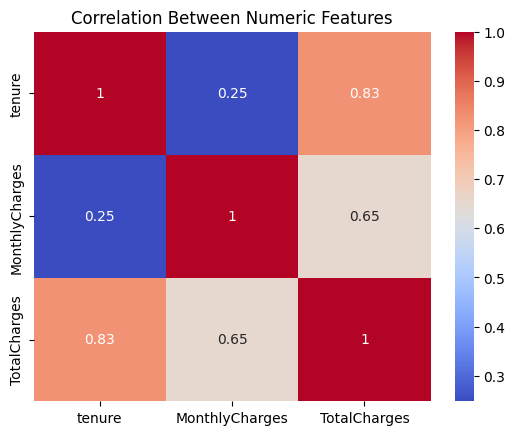

************************************************** Churn by Categorical Variables


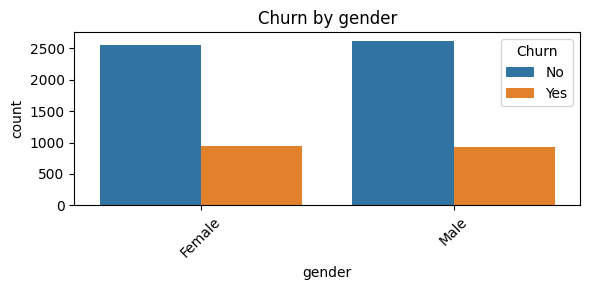

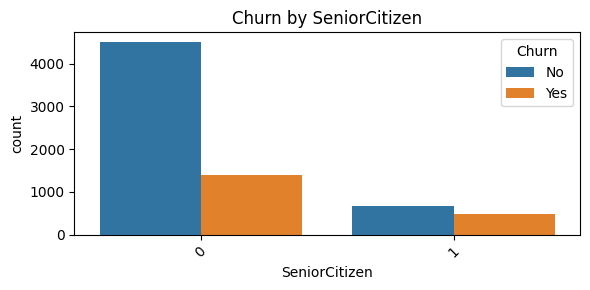

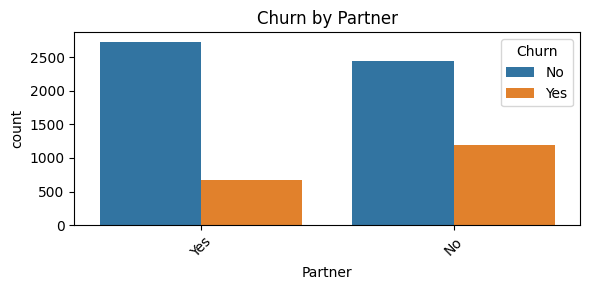

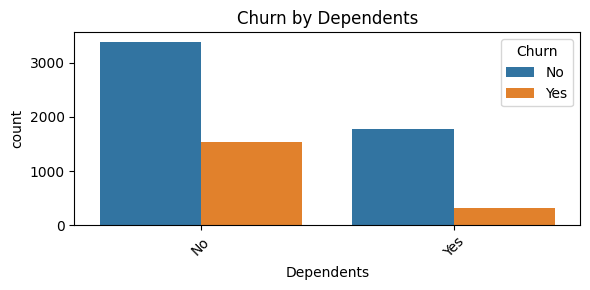

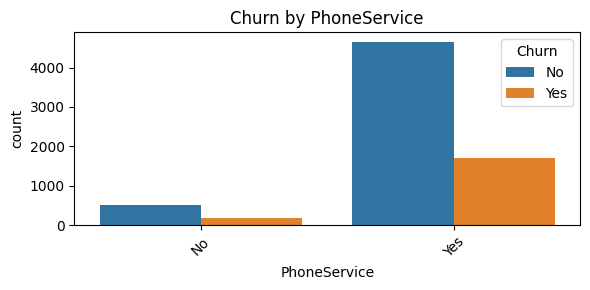

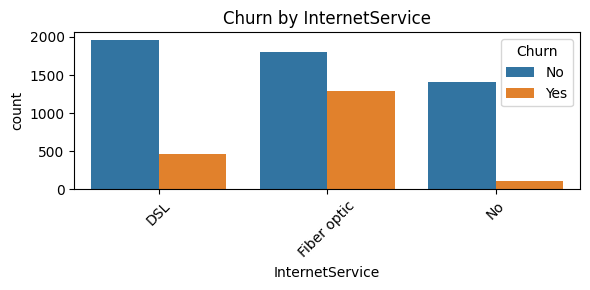

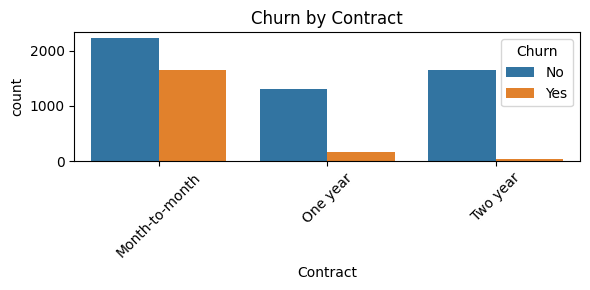

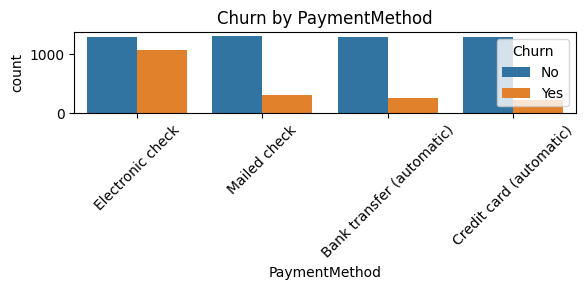

************************************************** Tenure Binning


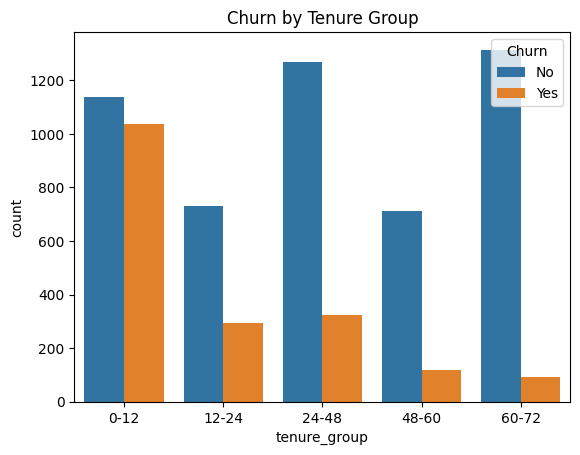

In [7]:
print(df.head(5))                # Check the first few rows
print(df.info())                # Check datatypes and nulls
print(df.describe())            # Summary stats for numerical columns
print(df.isnull().sum())        # Count missing values per column
print(df.duplicated().sum())    # Check for duplicate rows

print("*"*50, "Target Variable Distribution")
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

churn_rate = df['Churn'].value_counts(normalize=True)
print("Churn Rate:\n", churn_rate)

print("*"*50, "Check Data Types and Convert")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

print("*"*50, "Missing Value Heatmap")
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

print("*"*50, "Numerical Variable Histograms")
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[num_cols].hist(bins=30, figsize=(10, 6), layout=(1, 3))
plt.suptitle("Distribution of Numerical Features")
plt.show()

print("*"*50, "Correlation Matrix (Numerical Only)")
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Between Numeric Features")
plt.show()

print("*"*50, "Churn by Categorical Variables")
cat_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
            'PhoneService', 'InternetService', 'Contract', 'PaymentMethod']

for col in cat_cols:
    plt.figure(figsize=(6, 3))
    sns.countplot(data=df, x=col, hue='Churn')
    plt.title(f'Churn by {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

print("*"*50, "Tenure Binning")
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 60, 72],
                            labels=['0-12', '12-24', '24-48', '48-60', '60-72'])
sns.countplot(data=df, x='tenure_group', hue='Churn')
plt.title('Churn by Tenure Group')
plt.show()

In [8]:
# Handle Missing Values
df = df.dropna(subset=['TotalCharges'])
df.reset_index(drop=True, inplace=True)


# Encoding Categorical Variables

# Binary: Yes/No or 0/1
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

# Convert Yes/No to 1/0
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# Special binary cases
df['gender'] = df['gender'].map({'Female': 1, 'Male': 0})
df['SeniorCitizen'] = df['SeniorCitizen'].astype(int)  # already binary

# One-Hot Encode Multi-Class Columns
multi_cat_cols = ['InternetService', 'Contract', 'PaymentMethod', 'MultipleLines',
                  'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                  'TechSupport', 'StreamingTV', 'StreamingMovies']

df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)

# Feature Scaling
from sklearn.preprocessing import StandardScaler

scale_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

In [9]:
# Split Dataset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

X = df.drop(['customerID', 'Churn', 'tenure_group'], axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

In [10]:
# Train and Evaluate Individual Models

# Initialize models
logreg = LogisticRegression(max_iter=1000, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Fit models
logreg.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Predict
models = {'Logistic Regression': logreg, 'Random Forest': rf, 'XGBoost': xgb}

# Evaluation
def evaluate_models(models, X_test, y_test):
    results = []
    for name, model in models.items():
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else y_pred

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)

        results.append([
            name,
            round(accuracy, 3),
            round(precision, 3),
            round(recall, 3),
            round(f1, 3),
            round(auc, 3)
        ])
    results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'])
    return results_df

results_df = evaluate_models(models, X_test, y_test)
print(results_df)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:42:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                 Model  Accuracy  Precision  Recall  F1-Score    AUC
0  Logistic Regression     0.804      0.649   0.570     0.607  0.836
1        Random Forest     0.787      0.628   0.487     0.548  0.819
2              XGBoost     0.778      0.589   0.548     0.568  0.820


In [11]:
# Ensemble with Voting Classifier
ensemble = VotingClassifier(estimators=[
    ('logreg', logreg),
    ('rf', rf),
    ('xgb', xgb)
], voting='soft')  # soft uses predicted probabilities

ensemble.fit(X_train, y_train)

# Evaluate ensemble
y_pred_ensemble = ensemble.predict(X_test)
y_proba_ensemble = ensemble.predict_proba(X_test)[:, 1]

ensemble_results = {
    'Model': 'Ensemble (Voting)',
    'Accuracy': round(accuracy_score(y_test, y_pred_ensemble), 3),
    'Precision': round(precision_score(y_test, y_pred_ensemble), 3),
    'Recall': round(recall_score(y_test, y_pred_ensemble), 3),
    'F1-Score': round(f1_score(y_test, y_pred_ensemble), 3),
    'AUC': round(roc_auc_score(y_test, y_proba_ensemble), 3)
}

# Append to results
ensemble_results_df = pd.DataFrame([ensemble_results])
results_df = pd.concat([results_df, ensemble_results_df], ignore_index=True)
print(results_df)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:42:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                 Model  Accuracy  Precision  Recall  F1-Score    AUC
0  Logistic Regression     0.804      0.649   0.570     0.607  0.836
1        Random Forest     0.787      0.628   0.487     0.548  0.819
2              XGBoost     0.778      0.589   0.548     0.568  0.820
3    Ensemble (Voting)     0.792      0.630   0.524     0.572  0.834


In [12]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Base learners
base_learners = [
    ('logreg', logreg),
    ('rf', rf),
    ('xgb', xgb)
]

# Meta learner
meta_learner = LogisticRegression()

# Stacking Classifier
stack_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5)

# Fit
stack_model.fit(X_train, y_train)

# Predict
y_pred_stack = stack_model.predict(X_test)
y_proba_stack = stack_model.predict_proba(X_test)[:, 1]

# Evaluate
stack_results = {
    'Model': 'StackingClassifier',
    'Accuracy': round(accuracy_score(y_test, y_pred_stack), 3),
    'Precision': round(precision_score(y_test, y_pred_stack), 3),
    'Recall': round(recall_score(y_test, y_pred_stack), 3),
    'F1-Score': round(f1_score(y_test, y_pred_stack), 3),
    'AUC': round(roc_auc_score(y_test, y_proba_stack), 3)
}

# Append to results
stack_results_df = pd.DataFrame([stack_results])
results_df = pd.concat([results_df, stack_results_df], ignore_index=True)

# Show results
print(results_df)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:42:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:42:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:42:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:42:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:42:50] WARNING: /w

                 Model  Accuracy  Precision  Recall  F1-Score    AUC
0  Logistic Regression     0.804      0.649   0.570     0.607  0.836
1        Random Forest     0.787      0.628   0.487     0.548  0.819
2              XGBoost     0.778      0.589   0.548     0.568  0.820
3    Ensemble (Voting)     0.792      0.630   0.524     0.572  0.834
4   StackingClassifier     0.802      0.651   0.553     0.598  0.839


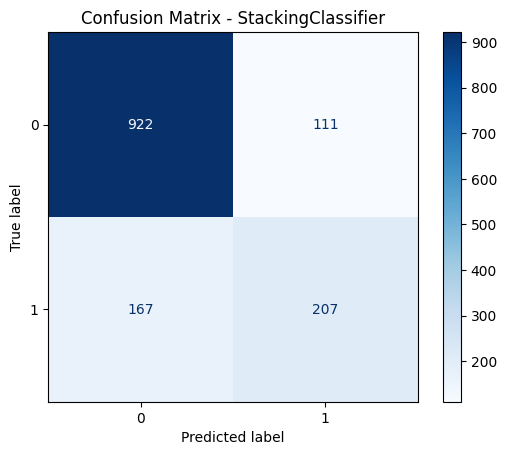

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_stack)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=stack_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - StackingClassifier")
plt.show()

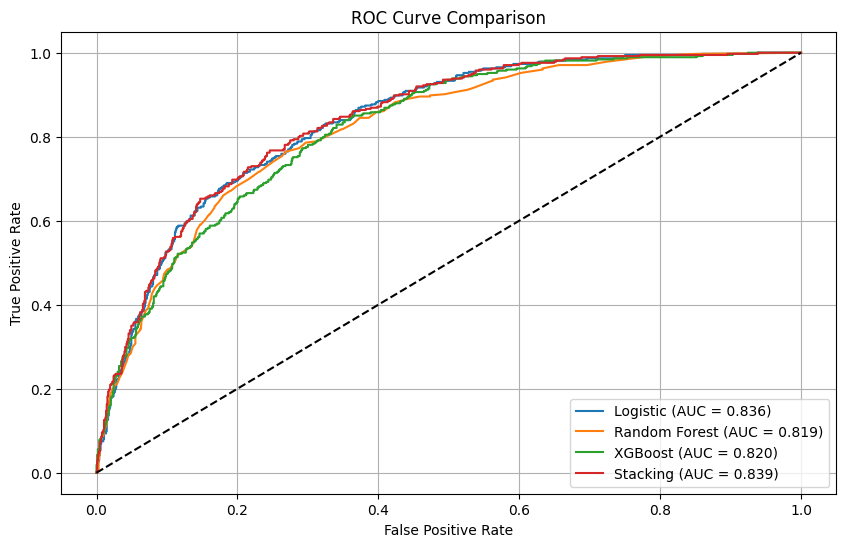

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get prediction probabilities
y_proba_logreg = logreg.predict_proba(X_test)[:, 1]
y_proba_rf = rf.predict_proba(X_test)[:, 1]
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

# Plot ROC curves
plt.figure(figsize=(10, 6))

# Logistic Regression
fpr, tpr, _ = roc_curve(y_test, y_proba_logreg)
plt.plot(fpr, tpr, label='Logistic (AUC = {:.3f})'.format(roc_auc_score(y_test, y_proba_logreg)))

# Random Forest
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
plt.plot(fpr, tpr, label='Random Forest (AUC = {:.3f})'.format(roc_auc_score(y_test, y_proba_rf)))

# XGBoost
fpr, tpr, _ = roc_curve(y_test, y_proba_xgb)
plt.plot(fpr, tpr, label='XGBoost (AUC = {:.3f})'.format(roc_auc_score(y_test, y_proba_xgb)))

# Stacking (if you've defined and trained 'stack_model')
y_proba_stack = stack_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba_stack)
plt.plot(fpr, tpr, label='Stacking (AUC = {:.3f})'.format(roc_auc_score(y_test, y_proba_stack)))

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

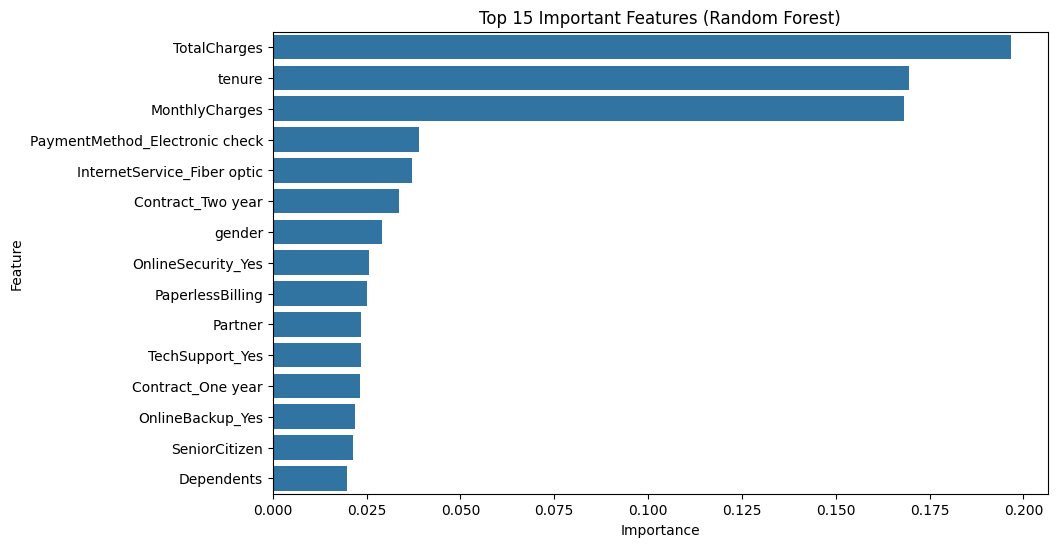

In [15]:
import seaborn as sns

# Using Random Forest for feature importance
importances = rf.feature_importances_
feature_names = X_train.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(15))
plt.title('Top 15 Important Features (Random Forest)')
plt.show()

In [16]:
import joblib

# Save the StackingClassifier model
joblib.dump(stack_model, 'stacking_model.pkl')
joblib.dump(X_train.columns.tolist(), "X_train_columns.pkl")

['X_train_columns.pkl']